In [1]:
from diodem import load_data
import numpy as np
import qmt
import imt

We will consider the lower body consisting of right leg (`r_shank` + `r_thigh`), `hip`, and left leg (`l_shank` and `l_thigh`).
First, define the nameing convention for these five coorindate systems. Then, define how the coordinate systems relate to each other.

We will choose the `hip` to be at the center of the estimation, i.e., it is assumed to freely float in space. The other coordinate systems are then rigidly connected to it or other coordinate systems that are rigidly connected to the `hip` coordinate system.

In [2]:
body_names = ["hip", "r_thigh", "r_shank", "l_thigh", "l_shank"]
graph = [-1, 0, 1, 0, 3]  # Parent indices corresponding to body_names
imt.utils.print_graph(graph, body_names)

-1 (Earth)
|
hip
├── r_thigh
│   └── r_shank
└── l_thigh
    └── l_shank


Then, prepare the IMU data. We will load test data from the `imt-diodem` dataset.

In [3]:
exp_id = 10
motion = "gait_slow"
Hz = 100
data = load_data(exp_id, motion, resample_to_hz=Hz)

In [4]:
imu_data = {
    "hip": {
        # you can read in the diodem documentation that the 'seg2' resembles the hip segment in this dataset
        "acc": data["seg2"]["imu_rigid"]["acc"],
        "gyr": data["seg2"]["imu_rigid"]["gyr"],
    },
    "r_thigh": {
        "acc": data["seg1"]["imu_rigid"]["acc"],
        "gyr": data["seg1"]["imu_rigid"]["gyr"],
    },
    "r_shank": {
        "acc": data["seg5"]["imu_rigid"]["acc"],
        "gyr": data["seg5"]["imu_rigid"]["gyr"],
    },
    "l_thigh": {
        "acc": data["seg3"]["imu_rigid"]["acc"],
        "gyr": data["seg3"]["imu_rigid"]["gyr"],
    },
    "l_shank": {
        "acc": data["seg4"]["imu_rigid"]["acc"],
        "gyr": data["seg4"]["imu_rigid"]["gyr"],
    },
}

Then, solve the motion tracking problem. Because we also want to visualize the motion, we will use the `JointPosition` `MethodWrapper` to estimate the physical connections from bodies to the joint centers. These connection vectors can then later be visualised.

In [5]:
methods = [
    # this method is used to estimate `-1` to `hip`
    imt.methods.VQF(offline=True),
    # this method is used for the 2D joint between `hip` and `r_thigh`
    imt.methods.JointPosition(imt.methods.RNNO()),
    # `r_thigh` and `r_shank`
    # we specify here the degree of freeom (dof) between two bodies this is because for a hinge joint we can 
    # not accurately estimate the connection vector component that is parallel to the hinge joint axis direction
    imt.methods.JointPosition(imt.methods.RNNO(), dof_is_1d=True),
    # `hip` and `l_thigh`
    imt.methods.JointPosition(imt.methods.RNNO()),
    # `l_thigh` and `l_shank`,
    imt.methods.JointPosition(imt.methods.RNNO(), dof_is_1d=True),
]
solver = imt.Solver(graph, methods=methods, Ts= 1 / Hz, body_names=body_names)
solution = solver.step(imu_data)

In [6]:
# `solution` contains both all body-to-earth orientation estimates as well as additional information such as the physical connection vectors
body_to_earth_rotations, extras = solution
print(body_to_earth_rotations.keys())

dict_keys(['hip', 'r_thigh', 'r_shank', 'l_thigh', 'l_shank'])


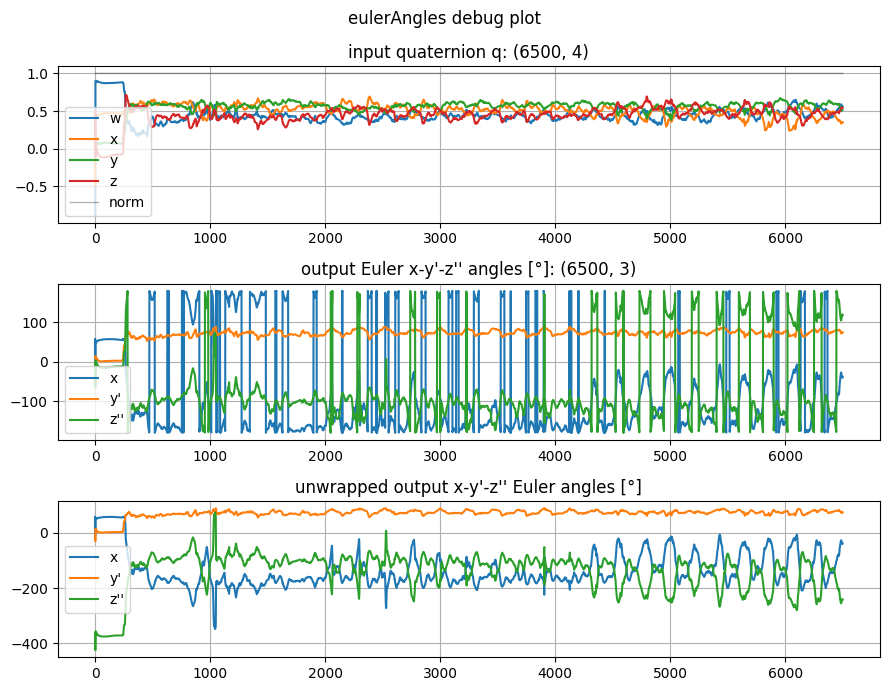

In [7]:
# suppose we are interest in the relative orientation from `hip` to `r_thigh`
q_hip_to_r_thigh = qmt.qmult(qmt.qinv(body_to_earth_rotations["r_thigh"]), body_to_earth_rotations["hip"])
# then we can verify that it is indeed a two-dimensional joint. Note that this only works because the `diodem` dataset has IMUs with well-defined sensor-to-segment orientations
_ = qmt.eulerAngles(q_hip_to_r_thigh, axes="xyz", plot=True)

Because the `diodem` dataset has optical motion capture (OMC) groundtruth, we can even compute the orientation errors.

In [8]:
for name_diodem, name in zip(["seg2", "seg1", "seg5", "seg3", "seg4"], body_names):
    # skip 5 seconds for initial convergence; convergence needs motion! and in the beginning there is none
    print(name, round(np.rad2deg(np.mean(np.abs(qmt.quatAngle(qmt.qrel(data[name_diodem]["quat"], body_to_earth_rotations[name])))[500:])), 2), "deg")

hip 2.96 deg
r_thigh 6.54 deg
r_shank 6.78 deg
l_thigh 5.61 deg
l_shank 7.07 deg


Finally, we can use the `imt-ring` package to visualize the motion. We can render it and show a video, or

In [ ]:
imt.utils.view(graph, body_to_earth_rotations, extras, hz=Hz, show_every_nth_frame=4, show_floor=False, show_stars=False, body_names=body_names, mode="offscreen")

To save the video permanently, provide the path to where the .mp4 is  saved by specifying `offscreen_mode_options=dict(output_path=...)`


we can open an interactive viewer.

In [10]:
imt.utils.view(graph, body_to_earth_rotations, extras, hz=Hz, show_every_nth_frame=4, show_floor=False, show_stars=False, body_names=body_names)

2024-12-08 14:46:57.675 python[12705:1411655] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-08 14:46:57.675 python[12705:1411655] +[IMKInputSession subclass]: chose IMKInputSession_Modern
